In [296]:
from collections import defaultdict
import numpy as np
import geopandas as gpd
import contextily as cx
from PIL import Image

import matplotlib
from matplotlib import pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = [12, 15]

Load ASS points

In [210]:
source = gpd.read_file("data/GTK_ASsoil_obs.csv")
geom = gpd.points_from_xy(source.POINT_X.astype("float"), source.POINT_Y.astype("float"))

points = gpd.GeoDataFrame(source.CLASS, crs="EPSG:3067", geometry=geom).to_crs("WGS84")

In [211]:
points.loc[0]

CLASS                                                ASS
geometry    POINT (25.768937832725747 64.77798766173387)
Name: 0, dtype: object

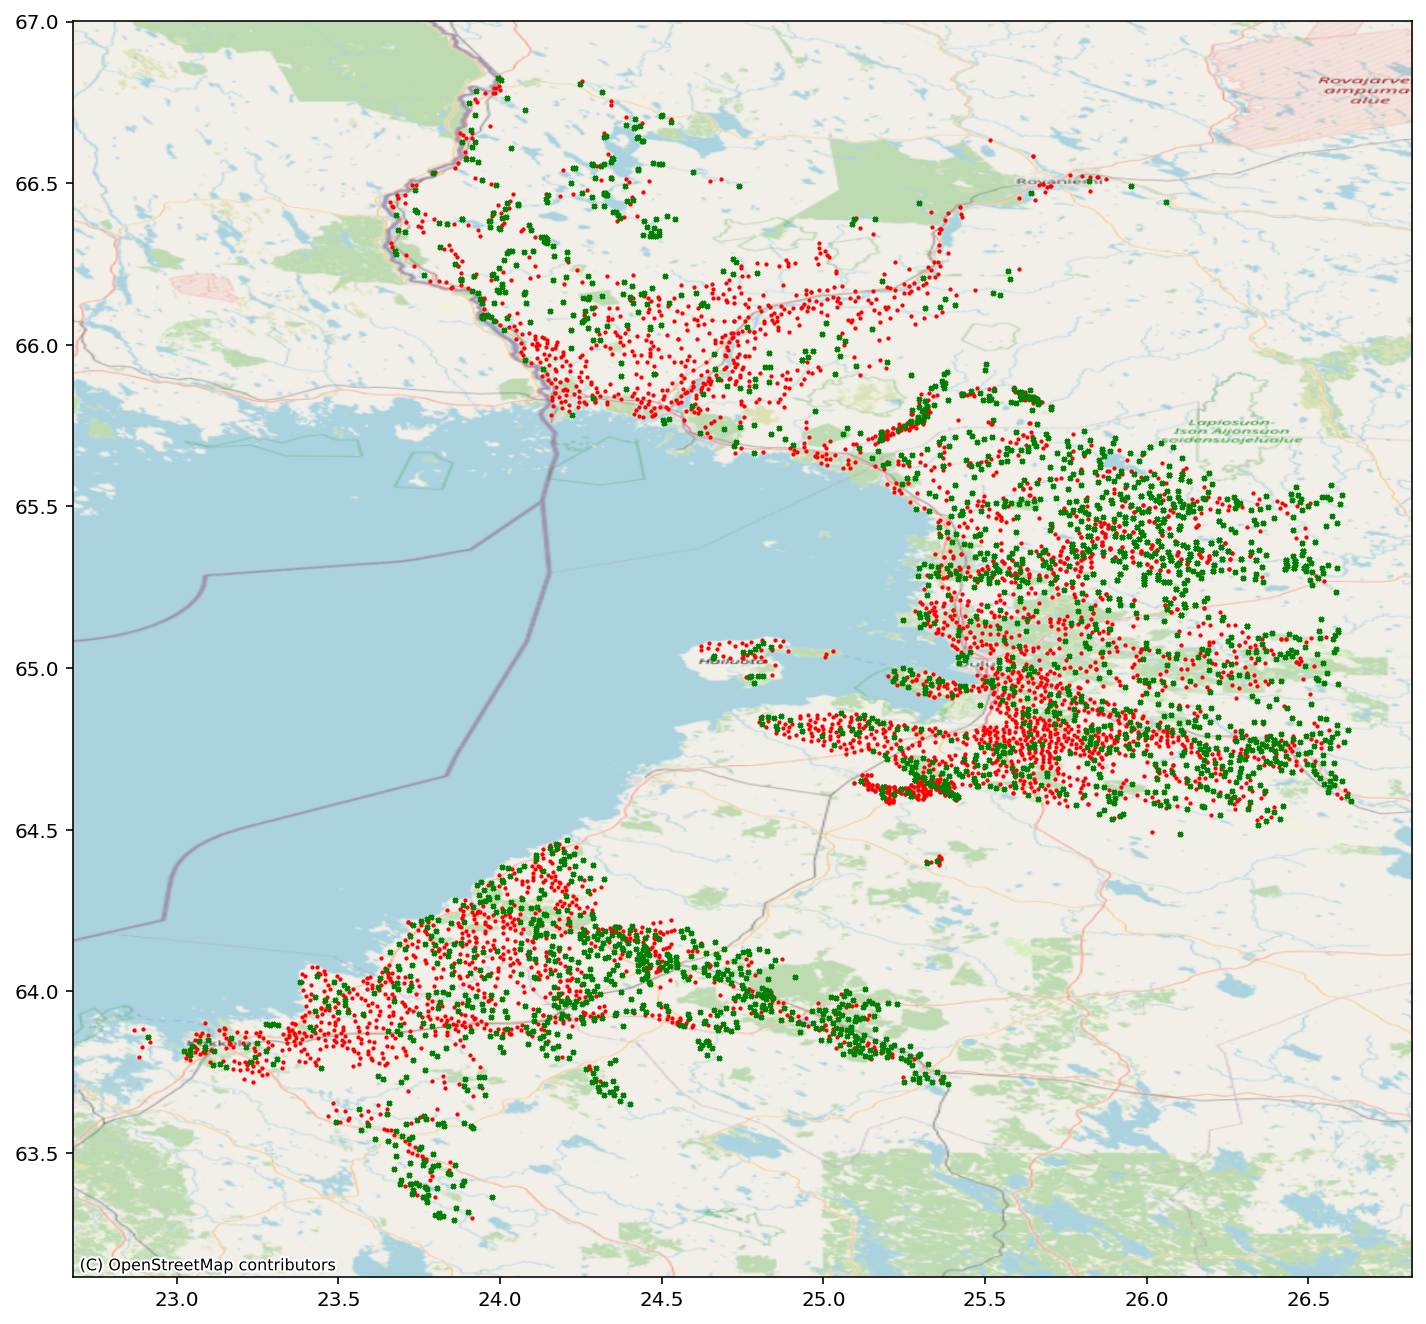

In [212]:
# CRS = "EPSG:3067"  # undisturbed view
CRS = "WGS84" #Web Mercator
pplot = points.to_crs(CRS)

base = pplot[pplot["CLASS"] == "ASS"].plot(c="r", marker='.', markersize=5)
pplot[pplot["CLASS"] != "ASS"].plot(ax=base, c="g", marker='x', markersize=5)

cx.add_basemap(base,crs=CRS, source=cx.providers.OpenStreetMap.Mapnik, zoom=8)

In [213]:
TILE_SIZE = 256
def project(p, zoom=6):
    lon, lat = p.geometry.x, p.geometry.y
    
    siny = np.sin(lat * np.pi / 180)
    siny = min(max(siny, -0.9999), 0.9999)
    
    x = TILE_SIZE * (0.5 + lon / 360)
    y = TILE_SIZE * (0.5 - np.log((1 + siny) / (1 - siny)) / (4 * np.pi))
    
    scale = 2**zoom

    tx = x * scale // TILE_SIZE
    ty = y * scale // TILE_SIZE

    px = x * scale % TILE_SIZE // 1
    py = y * scale % TILE_SIZE // 1

    return (int(zoom), int(tx), int(ty)), (px, py)

In [214]:
points_per_tile = defaultdict(list)

for idx, p in points.iterrows():
    for z in range(3, 20):
        tile, (px, py) = project(p, zoom=z)
        points_per_tile[tile].append((px, py, p.CLASS))

In [297]:


#convert to array
def load_map(points, tiles, zoom_level):
    RGB_list=[]
    points_tiles_list=[]
    
    for idx, p in points.iterrows():
        #for z in range(3, 20):
        (z, tx, ty), (px, py) = project(p, zoom=zoom_level)
        
        fname = tiles.format(z=z, x=tx, y=ty)
        im = Image.open(fname)    
        arr_img= np.array(im)
        
        Red,Green,Blue=arr_img[int(px),int(py)]
    
        
        points_tiles_list.append({"z": z, "tile_x": tx, "tile_y": ty, "x": px, "y": py, "class": p.CLASS})
        RGB_list.append({"R":Red,"G":Green, "B":Blue, "CLASS":c})
        
    df_points_tiles=gpd.GeoDataFrame(points_tiles_list)
    df_coor_points=df_points_tiles[['x','y','class']]
    df_RGB=gpd.GeoDataFrame(RGB_list)
    #return np.array(df_coor_points['x']), np.array(df_coor_points['y'])
    return df_RGB,df_coor_points


In [286]:
df_basic,_=load_map(points, tiles_basic, 10)

In [287]:
#df_load

In [288]:
df_esri,_=load_map(points, tiles_esri, 10)

In [293]:
#df_esri orthos

In [294]:
df_orthos,_=load_map(points, tiles_orthos, 10)

In [298]:
df_orthos.head()

R    G   B  CLASS
0  82  101  71  52416
1  81  103  67  52416
2  71   90  60  52416
3  61   85  53  52416
4  77   86  59  52416

In [290]:
# tiles_bing_hybrid = "/Users/akusok/Documents/ios-as-soils/MapTilesDownloader/src/output/bing_hybrid_finland/{z}/{x}/{y}.png"
#tiles_bing_sat = "/Users/akusok/Documents/ios-as-soils/MapTilesDownloader/src/output/bing_satellite/{z}/{x}/{y}.png"
#tiles_carto_light = "/Users/akusok/Documents/ios-as-soils/MapTilesDownloader/src/output/carto_light/{z}/{x}/{y}.png"
#tiles_wikimedia = "/Users/akusok/Documents/ios-as-soils/MapTilesDownloader/src/output/wikimedia/{z}/{x}/{y}.png"

tiles_esri = "/Users/tamiratatsemegiorgis/project/MapTilesViewer/esri/{z}/{x}/{y}.png"

tiles_orthos ="/Users/tamiratatsemegiorgis/project/MapTilesViewer/orthos/{z}/{x}/{y}.png"
tiles_basic ="/Users/tamiratatsemegiorgis/project/MapTilesViewer/basic/{z}/{x}/{y}.png"

In [299]:


def display_pixel(p, zoom, tileset):
    
    (tz, tx, ty), (px, py) = project(p, zoom=zoom)
    fname = tileset.format(z=tz, x=tx, y=ty)
    im = Image.open(fname)    
    plt.imshow(im, interpolation="lanczos")
        
    # print other points
    for (px1, py1, c) in points_per_tile[(tz, tx, ty)]:
        if px1 == px and py1 == py:
            # print point
            plt.plot(px, py, "o", c="w", markersize=25)
            plt.plot(px, py, "*", c="g" if c != "ASS" else "r", markersize=11)
        else:
            plt.plot(px1, py1, "*", c="w" if c != "ASS" else "r", markersize=11)
        
    
    plt.show()

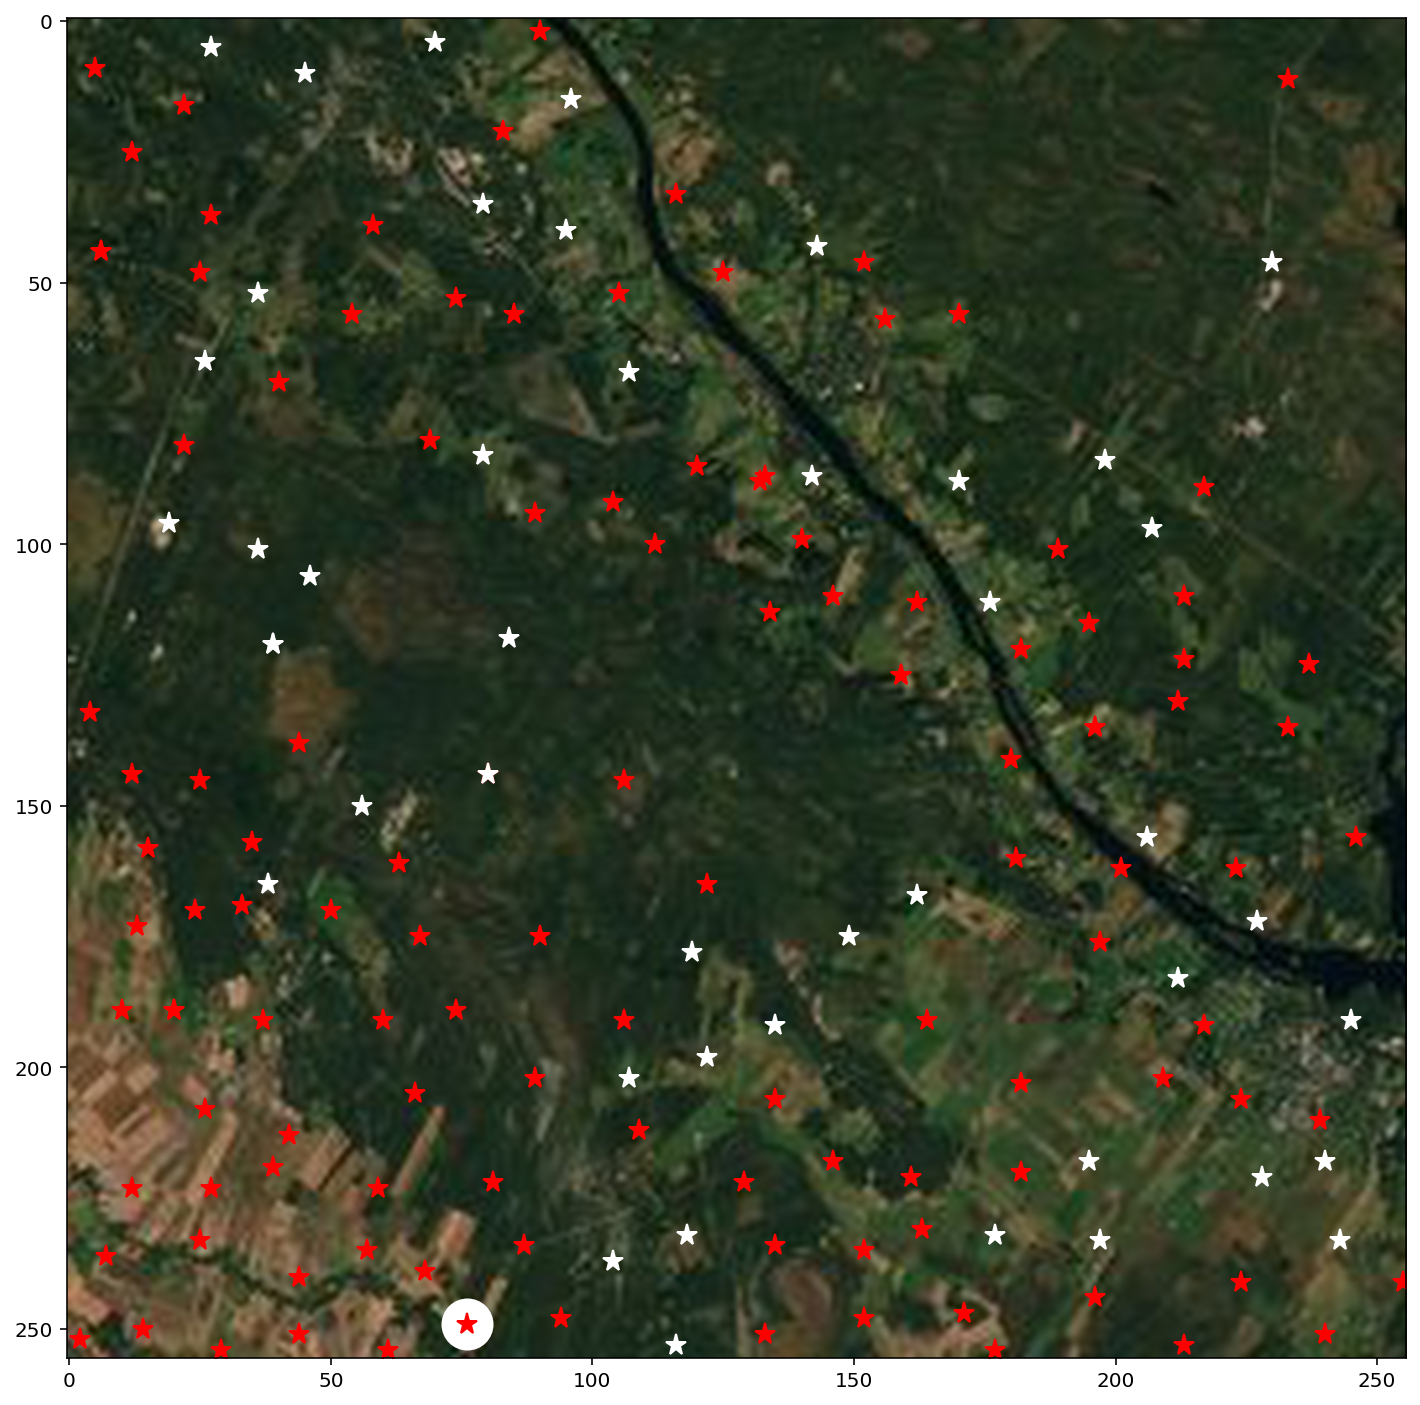

In [302]:
display_pixel(points.iloc[0], 10, tiles_esri)